# <center>Сегментация космических аппаратов
Датасет был взят [<b>отсюда</b>](https://github.com/Yurushia1998/SatelliteDataset)

<img src='./imgs/preview.png'></img>

* Данный датасет состоит из 3 116 изображений и масок как синтезированных, так и реальных изображений спутников и космических станций (размер масок — 1 280x720).

* Каждый космический аппарат разделён максимум на три части, включая корпус, солнечную панель и антенну, помеченные, соответственно, тремя цветами — зелёным, красным и синим.

* В папке `images` находятся изображения, в папке `mask` — маски объектов.

* Изображение с индексом 0-1002 имеет точную маску, а изображения с индексом 1003-3116 — грубую маску.

* Наборы данных разделены на две части: обучающую выборку, включая 403 точные маски из индексов 0-402, и 2 114 грубых масок из индекса 1003-3116.

* Набор данных `val` включает 600 изображений с точной маской, проиндексированных от 403 до 1002.

Будем использовать модель семейства *YOLO*. Импортируем необходимые библиотеки

In [1]:
import os
import cv2 as cv
import torch
import numpy as np
import re
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ultralytics.models import YOLO
from torchmetrics import JaccardIndex
from torchvision import io
pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
DATASET_PATH = './dataset'
IMG_PATH = './data/images'
MASK_PATH = './data/mask'

Создадим функции для удобства обработки датасета

In [2]:
# 'img_resize_001.png' -> '001'
def get_image_index(img_name:str) -> str:
    return re.findall(r'\d+', img_name)[0]

# 'img_resize_001.png' -> 'img_resize_001'
def get_image_name(img_name:str) -> str:
    return re.findall(r'([a-zA-Z0-9_-]+)\.', img_name)[0]

# 'img_resize_001_mask.png' -> 'img_resize_001.txt'
def modify_mask_name(mask_name:str) -> str:
    result = re.sub(r'\.png$', '.txt', mask_name)
    result = re.sub(r'\_mask', '', result)
    return result

Визуализируем несколько примеров из датасета

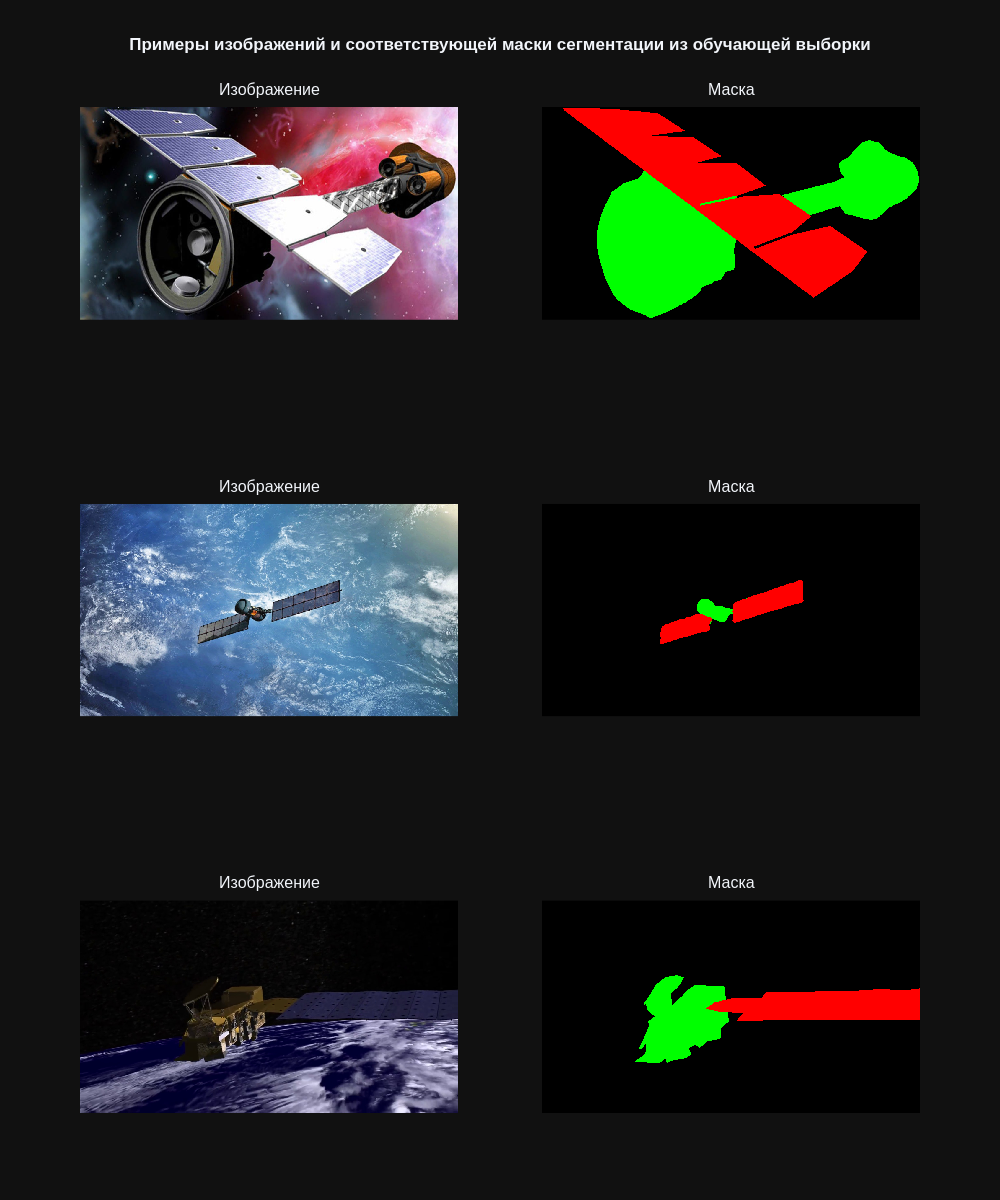

In [3]:
nrows = 3
ncols = 2
grid = make_subplots(rows=nrows, cols=ncols, subplot_titles=['Изображение', 'Маска']*nrows)
for row, img in zip(
    range(1, nrows+1),
    os.listdir(os.path.join(IMG_PATH, 'train'))[:nrows]
):
    # Add image
    grid.add_trace(
        trace=px.imshow(
            # BGR -> RGB
            cv.cvtColor(
                cv.imread(os.path.join(IMG_PATH, 'train', img)),
                cv.COLOR_BGR2RGB
            )
        ).data[0],
        row=row,
        col=1
    )
    # Add mask
    grid.add_trace(
        trace=px.imshow(
            # BGR -> RGB
            cv.cvtColor(
                cv.imread(os.path.join(MASK_PATH, 'train', get_image_name(img)+'_mask.png')),
                cv.COLOR_BGR2RGB
            )
        ).data[0],
        row=row,
        col=2
    )
# Configure plot
grid.update_layout(
    width=1000, 
    height=1200,
    title='<b>Примеры изображений и соответствующей маски сегментации из обучающей выборки</b>',
    title_x=0.5
).update_xaxes(
    visible=False
).update_yaxes(
    visible=False
).show()

Сейчас данные находятся в следующей структуре:

In [3]:
!tree ./data -d

./data
├── images
│   ├── train
│   └── val
└── mask
    ├── train
    └── val

6 directories


С помощью следующей ячейки создадим структуру датасета, которая необходима для *YOLO*

Код проходит по всем файлам масок в папке `./data/mask`. Для каждого файла маски создается соответствующий файл метки в формате `.txt`.

С помощью *OpenCV* находим контуры объектов на каждом канале маски и преобразуем их в формат $(x_1, y_1, x_2, y_2, \dots, x_n, y_n)$

В результирующем файле-таргете `*.txt` получается следующая структура: `<class> <x1, y1, x2, y2, ...>`, где `<class>` соответствует каналу *RGB* изображения (0, 1 или 2). На 0 канале размечены солнечные панели, на 1 - основное тело аппарата, на 2 - антенны

In [4]:
for sample in ['train', 'val']:
    labels_path = os.path.join(DATASET_PATH, sample, 'labels')
    images_path = os.path.join(DATASET_PATH, sample, 'images')
    # Make train and val dirs
    if not os.path.exists(labels_path):
        os.mkdir(labels_path)
    # Check if labels already exists
    if len(os.listdir(labels_path)) == 0:
        # Iterate over all segmentation masks
        for mask_name in os.listdir(os.path.join(MASK_PATH, sample)):
            # Tensor [C, H, W]
            img = io.read_image(os.path.join(MASK_PATH, sample, mask_name))
            height, width = img.shape[1], img.shape[2]
            # *_mask.png -> *.txt for label file
            label_name = modify_mask_name(mask_name)
            # img_resize_1003_mask.png -> 1003
            img_idx = get_image_index(mask_name)
            # Target string initial state
            labels_string = ''
            # Iterate over R, G, B (0, 1, 2) channels,
            # each channel contains a mask of a certain class:
            # 0 - solar panel, 1 - body, 2 - antenna
            for channel in range(3):
                # Skip empty channel without segmentation mask
                if img[channel].max().item() == 0:
                    continue
                # Get countours of segmented objects 
                contours = cv.findContours(img[channel].numpy(), mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_NONE)[0]
                for contour in contours:
                    # Reshape countour to 1D array: [x1, y1, x2, y2, ...]
                    contour_squeezed = contour.reshape(-1,).tolist()
                    # Normalize contour coordinates
                    for coord_idx in range(len(contour_squeezed)):
                        current_coordinate = contour_squeezed[coord_idx]
                        if bool(coord_idx % 2):
                            # Normalize Y, convert to string for more convenient writing to a file
                            contour_squeezed[coord_idx] = str(current_coordinate / height)
                        else:
                            # Normalize X
                            contour_squeezed[coord_idx] = str(current_coordinate / width)
                    # Convert to string 'x1 y1 x2 y2 ...'
                    string_contour = ' '.join(contour_squeezed)
                    # Add row to target in format '<class> <segmentation_contour>'
                    labels_string += f"{channel} {string_contour}\n"
            # Write target file
            with open(os.path.join(labels_path, label_name), 'w') as txt_label:
                txt_label.write(labels_string.rstrip(r'\n'))
        # Delete all images without segmentation masks
        for img_name in os.listdir(images_path):
            if get_image_name(img_name) not in list(map(get_image_name, os.listdir(labels_path))):
                os.remove(os.path.join(images_path, img_name))

Проверим теперь структуру датасета

In [5]:
!tree ./dataset -d

./dataset
├── train
│   ├── images
│   └── labels
└── val
    ├── images
    └── labels

6 directories


Загрузим модель `yolov8x-seg` для задачи сегментации. `x` в названии означает, что эта модель имеет больше всего весов, чем остальные

In [6]:
yolo = YOLO('yolov8x-seg.pt')

Дообучаем модель на новых данных в течение 50-ти эпох

In [7]:
results = yolo.train(
    model='yolov8x-seg.pt',
    data='yolo.yaml',
    epochs=50,
    imgsz=512,
    batch=8,
    pretrained=True
)

New https://pypi.org/project/ultralytics/8.1.14 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.13 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=yolo.yaml, epochs=50, time=None, patience=50, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

2024-02-15 11:41:24.037755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 11:41:24.037789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 11:41:24.073501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

train: Scanning /home/deep_learning/Spacecraft segmentation/dataset/train/labels.cache... 1014 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1014/1014 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/deep_learning/Spacecraft segmentation/dataset/val/labels.cache... 403 images, 0 backgrounds, 0 corrupt: 100%|██████████| 403/403 [00:00<?, ?it/s]


Plotting labels to runs/segment/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/segment/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.94G     0.9697      1.783      1.531      1.219         55        512: 100%|██████████| 127/127 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.11it/s]


                   all        403       2121      0.386      0.359      0.269      0.162      0.429      0.377      0.293      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.91G      1.174      2.051      1.417      1.355         51        512: 100%|██████████| 127/127 [00:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.44it/s]


                   all        403       2121     0.0674      0.342     0.0546      0.033     0.0693      0.349      0.054     0.0315

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.92G      1.253      2.115      1.458      1.408         33        512: 100%|██████████| 127/127 [00:25<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.57it/s]

                   all        403       2121      0.511      0.325      0.319      0.192      0.566      0.341      0.347      0.202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.91G      1.178      2.046      1.387      1.363         51        512: 100%|██████████| 127/127 [00:26<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.71it/s]

                   all        403       2121      0.426       0.34        0.3      0.182      0.452      0.349      0.313      0.186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50       5.9G      1.153      1.937      1.314      1.349         39        512: 100%|██████████| 127/127 [00:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.23it/s]

                   all        403       2121      0.501      0.354      0.352      0.215      0.537      0.372      0.382      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.92G        1.1      1.873      1.253      1.323         46        512: 100%|██████████| 127/127 [00:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.69it/s]


                   all        403       2121      0.527       0.45      0.426      0.275      0.655      0.415      0.444      0.285

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.93G      1.027      1.787      1.127      1.264         52        512: 100%|██████████| 127/127 [00:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.99it/s]


                   all        403       2121      0.504      0.434      0.415      0.268      0.528      0.445      0.427      0.272

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.95G      1.029      1.706      1.104      1.274         41        512: 100%|██████████| 127/127 [00:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.75it/s]

                   all        403       2121      0.579      0.432      0.438      0.289      0.619      0.446      0.454      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.92G     0.9917      1.688      1.051      1.247         50        512: 100%|██████████| 127/127 [00:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.96it/s]

                   all        403       2121      0.602      0.435      0.438      0.286      0.611      0.455      0.461      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50       5.9G     0.9951      1.635      1.044       1.24         74        512: 100%|██████████| 127/127 [00:25<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.82it/s]


                   all        403       2121      0.576      0.438      0.441      0.294      0.604      0.451      0.458      0.298

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.96G     0.9596      1.526      1.002       1.23         45        512: 100%|██████████| 127/127 [00:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.76it/s]


                   all        403       2121      0.572      0.454      0.469      0.312      0.621      0.473      0.495      0.328

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.94G     0.9502      1.536     0.9853      1.227         60        512: 100%|██████████| 127/127 [00:25<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.91it/s]

                   all        403       2121      0.619      0.454      0.463      0.316      0.665      0.463      0.488      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.95G     0.9249      1.549     0.9747      1.211         45        512: 100%|██████████| 127/127 [00:25<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.66it/s]

                   all        403       2121       0.63      0.451      0.477      0.331      0.648       0.46      0.494      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.92G     0.9001      1.492     0.9317      1.198         39        512: 100%|██████████| 127/127 [00:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.75it/s]


                   all        403       2121      0.618      0.465      0.475      0.322      0.645      0.477      0.485      0.326

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.99G     0.8774       1.43     0.8702      1.163         60        512: 100%|██████████| 127/127 [00:25<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.80it/s]


                   all        403       2121        0.6      0.482      0.471      0.325       0.61      0.494      0.479      0.329

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.93G     0.8409      1.388     0.8357      1.138         28        512: 100%|██████████| 127/127 [00:25<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.87it/s]

                   all        403       2121      0.674      0.478      0.496      0.344      0.702      0.486      0.512      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.93G     0.8457      1.376     0.8449      1.154         63        512: 100%|██████████| 127/127 [00:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.79it/s]

                   all        403       2121      0.664      0.474      0.492      0.337       0.69      0.496      0.513      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.91G       0.83      1.354     0.8186      1.138         51        512: 100%|██████████| 127/127 [00:25<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.46it/s]

                   all        403       2121      0.678      0.471      0.498      0.342      0.693       0.48      0.506      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.93G     0.8182      1.364     0.8314      1.141         39        512: 100%|██████████| 127/127 [00:26<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.57it/s]

                   all        403       2121      0.676      0.506      0.519      0.357      0.718      0.509      0.528      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50       5.9G     0.7994      1.278     0.7601      1.115         68        512: 100%|██████████| 127/127 [00:26<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.01it/s]


                   all        403       2121       0.67      0.489      0.514      0.366      0.679      0.495      0.526       0.37

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50         6G     0.7781      1.245     0.7356      1.108         37        512: 100%|██████████| 127/127 [00:26<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.04it/s]

                   all        403       2121      0.623      0.499      0.514      0.361      0.746      0.457      0.519      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.92G     0.7553       1.22     0.7129      1.095         60        512: 100%|██████████| 127/127 [00:26<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.63it/s]

                   all        403       2121      0.678      0.495      0.524      0.378      0.696      0.508       0.54      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.89G     0.7435      1.182      0.704      1.089         40        512: 100%|██████████| 127/127 [00:26<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.69it/s]


                   all        403       2121      0.679      0.494      0.525      0.373      0.694      0.503      0.534      0.372

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.95G     0.7461      1.209     0.6998      1.078         46        512: 100%|██████████| 127/127 [00:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.83it/s]


                   all        403       2121      0.714      0.479      0.516      0.367      0.753      0.494      0.533      0.369

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50         6G     0.7304      1.164     0.6672      1.078         37        512: 100%|██████████| 127/127 [00:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.83it/s]

                   all        403       2121      0.724      0.495      0.533      0.377      0.724      0.513      0.544      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.97G     0.7206      1.161     0.6579      1.071         53        512: 100%|██████████| 127/127 [00:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.99it/s]


                   all        403       2121      0.667      0.494      0.515      0.365      0.695        0.5      0.527      0.362

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.94G     0.7223      1.138     0.6544      1.072         44        512: 100%|██████████| 127/127 [00:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.36it/s]


                   all        403       2121       0.69      0.515      0.537      0.386      0.736      0.528      0.553      0.386

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.98G     0.7038      1.122      0.643      1.059         47        512: 100%|██████████| 127/127 [00:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.02it/s]


                   all        403       2121      0.739      0.489      0.534      0.381      0.743      0.502      0.538      0.383

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.87G      0.712      1.086     0.6311      1.056         45        512: 100%|██████████| 127/127 [00:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.06it/s]


                   all        403       2121      0.701      0.503      0.542      0.389      0.719      0.509      0.544      0.385

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50       5.9G     0.6749      1.061     0.5939      1.043         48        512: 100%|██████████| 127/127 [00:26<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]


                   all        403       2121      0.698      0.502      0.533      0.384      0.776      0.492      0.547      0.386

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.91G     0.6625      1.051     0.5773       1.03         67        512: 100%|██████████| 127/127 [00:26<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.91it/s]

                   all        403       2121      0.679      0.519      0.531      0.386      0.718      0.521      0.539      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.93G     0.6595      1.009     0.5684      1.023         30        512: 100%|██████████| 127/127 [00:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.06it/s]

                   all        403       2121      0.739      0.499      0.539      0.386      0.758      0.497      0.548      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.92G     0.6359     0.9974     0.5531      1.019         63        512: 100%|██████████| 127/127 [00:25<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.54it/s]


                   all        403       2121      0.694      0.498      0.531      0.386      0.796      0.492      0.548      0.383

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.99G     0.6338     0.9873     0.5385       1.01         83        512: 100%|██████████| 127/127 [00:25<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.95it/s]

                   all        403       2121      0.712      0.494      0.534      0.388      0.739      0.505      0.548      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.94G     0.6219     0.9659     0.5294       1.01         45        512: 100%|██████████| 127/127 [00:25<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.59it/s]

                   all        403       2121      0.672      0.511      0.531      0.389      0.727      0.512      0.549      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.94G     0.6154     0.9551     0.5208     0.9988         39        512: 100%|██████████| 127/127 [00:25<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.47it/s]

                   all        403       2121      0.762      0.507      0.558      0.411      0.781      0.518      0.573      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.97G     0.6135     0.9375     0.5067     0.9928         51        512: 100%|██████████| 127/127 [00:25<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


                   all        403       2121      0.692      0.528      0.537      0.396      0.727      0.533      0.555      0.396

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.96G     0.6035     0.9352     0.5004     0.9925         47        512: 100%|██████████| 127/127 [00:25<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.27it/s]

                   all        403       2121      0.722      0.506       0.55      0.404      0.754      0.512      0.563        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.95G      0.594      0.918     0.4821     0.9825         43        512: 100%|██████████| 127/127 [00:25<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.35it/s]

                   all        403       2121      0.733      0.526      0.559      0.409      0.753       0.54      0.573      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.93G     0.5861     0.8948     0.4705     0.9772         43        512: 100%|██████████| 127/127 [00:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.39it/s]


                   all        403       2121      0.788      0.503      0.553       0.41      0.805      0.517      0.567      0.407
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.86G     0.5585     0.8676     0.4426     0.9754         35        512: 100%|██████████| 127/127 [00:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]

                   all        403       2121       0.73      0.531      0.548        0.4      0.743      0.541      0.566      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.83G     0.5534     0.8263     0.4257     0.9731         20        512: 100%|██████████| 127/127 [00:24<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.48it/s]

                   all        403       2121      0.719        0.5      0.545      0.399       0.77      0.503      0.556      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.84G     0.5381     0.8043     0.3948     0.9636         22        512: 100%|██████████| 127/127 [00:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.49it/s]

                   all        403       2121      0.765      0.512      0.559      0.413       0.77      0.535      0.576      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.86G     0.5304     0.8004     0.3791     0.9569         29        512: 100%|██████████| 127/127 [00:25<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.54it/s]

                   all        403       2121      0.739      0.508      0.546      0.403      0.766      0.517      0.564      0.405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.82G      0.526     0.7873     0.3801     0.9585         21        512: 100%|██████████| 127/127 [00:25<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]

                   all        403       2121      0.757      0.507      0.552      0.409      0.789      0.519      0.573      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.85G     0.5076     0.7391     0.3651     0.9426         23        512: 100%|██████████| 127/127 [00:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.73it/s]

                   all        403       2121      0.718      0.533      0.557      0.412      0.741      0.545      0.575      0.415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.85G     0.4946     0.7427     0.3531     0.9272         28        512: 100%|██████████| 127/127 [00:27<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.01it/s]

                   all        403       2121      0.783      0.514       0.56      0.419      0.807      0.523      0.571      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.86G      0.476     0.7357     0.3381     0.9217         21        512: 100%|██████████| 127/127 [00:27<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.44it/s]

                   all        403       2121      0.744      0.541      0.565      0.425      0.758      0.553      0.585      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.83G     0.4756     0.7175      0.335     0.9223         23        512: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.84it/s]

                   all        403       2121      0.749      0.515      0.557      0.415      0.772      0.526      0.575      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.83G     0.4606     0.7048     0.3166     0.9122         20        512: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.78it/s]

                   all        403       2121      0.755      0.518      0.563      0.422       0.78      0.528      0.579      0.419



50 epochs completed in 0.435 hours.
Optimizer stripped from runs/segment/train2/weights/last.pt, 143.9MB
Optimizer stripped from runs/segment/train2/weights/best.pt, 143.9MB

Validating runs/segment/train2/weights/best.pt...
Ultralytics YOLOv8.1.13 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
YOLOv8x-seg summary (fused): 295 layers, 71723545 parameters, 0 gradients, 343.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.39it/s]


                   all        403       2121      0.744      0.541      0.565      0.425      0.758      0.553      0.585      0.426
           solar panel        403        919      0.844      0.699       0.75      0.618      0.852      0.706      0.764      0.628
                  body        403        948      0.749      0.454       0.47      0.318       0.75      0.457      0.473      0.314
               antenna        403        254       0.64       0.47      0.475      0.339      0.673      0.496      0.518      0.335
Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/train2


## <center>Оценка качества</center>
### История обучения
<img src='./imgs/results.png' width=1400></img>

Возможно, если дать модели больше времени на обучение, то получится достичь ещё более высоких показателей метрик на валидации без переобучения

Загрузим наилучшую модель

In [4]:
best_model_path = './runs/segment/train2/weights/best.pt'
best_yolo = YOLO(best_model_path)

Посчитаем метрики на валидационной выборке

In [9]:
val_metrics = best_yolo.val(split='val')

Ultralytics YOLOv8.1.13 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
YOLOv8x-seg summary (fused): 295 layers, 71723545 parameters, 0 gradients, 343.7 GFLOPs


val: Scanning /home/deep_learning/Spacecraft segmentation/dataset/val/labels.cache... 403 images, 0 backgrounds, 0 corrupt: 100%|██████████| 403/403 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:07<00:00,  3.35it/s]


                   all        403       2121      0.744      0.542      0.565      0.425      0.758      0.553      0.585      0.424
           solar panel        403        919      0.844      0.699       0.75      0.618      0.853      0.706      0.764      0.627
                  body        403        948      0.746      0.454      0.469      0.317      0.749      0.457      0.473      0.314
               antenna        403        254      0.642      0.472      0.475      0.341      0.672      0.496      0.518      0.332
Speed: 0.1ms preprocess, 10.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val2


### Визуализация метрик на валидационной выборке
#### *PR curve*
<img src='./imgs/MaskPR_curve.png' height=800></img>

#### *Confusion matrix*
<img src='./imgs/confusion_matrix_normalized.png' height=800></img>

### *F1-confidence curve*
<img src='./imgs/MaskF1_curve.png' height=800></img>

Вручную посчитаем метрику $\text{mIoU}$ для валидационной выборки, т.к. в валидаторе *YOLO* не используется эта метрика по-умолчанию

In [5]:
# Binary for the reason that we want to calculate the mIoU for objects,
# and not its individual parts 
IoU = JaccardIndex(task='binary').cuda()
val_img_path = './dataset/val/images'
# Cumulative array
iou_array = np.array([])
# Iterate over every image in val sample
for image_name in os.listdir(val_img_path):
    # *.png -> *_mask.png to get real label from another folder ./data/mask/val
    real_mask_name = get_image_name(image_name) + '_mask.png'
    # Predict segmentation masks for image
    output = best_yolo.predict(os.path.join(val_img_path, image_name), verbose=False)
    # Read real mask in grayscale
    real_mask_gray = cv.imread(
        os.path.join(MASK_PATH, 'val', real_mask_name),
        flags=cv.IMREAD_GRAYSCALE
    )
    # Convert all pixels with brightness > 0 from [0, ..., 255] to [0, 1]
    _, real_mask_binary = cv.threshold(
        # Match real size with predicted segmentation mask size:
        # YOLO predicted seg. masks from `output.masks.data` is [0.4 * H, 0.4 * W],
        # our original sizes of all images is [H=720, W=1280], then we want resize it to [H=288, W=512]
        cv.resize(real_mask_gray, (512, 288)), # OpenCV using dsize [W, H]
        # Every not-zero pixel turns 1
        thresh=1,
        maxval=1,
        type=cv.THRESH_BINARY
    )
    # Skip computing IoU if no detections
    if output[0].masks is not None:
        # Tensor [C, H, W], where C - number of detections,
        # for example [2, H, W] means that model predicted at least 2 objects on image 
        pred_masks = output[0].masks.data
        # Make cumulative mask [H, W] for predictions
        pred_mask_binary = np.zeros_like(
            real_mask_binary, 
            dtype=np.float32
        )
        # Iterate over every channel C (every detected object) on predictions
        for mask in pred_masks:
            # Combine all objects on one mask (reduce dims from [C, H, W] to [H, W])
            pred_mask_binary = cv.bitwise_or(
                mask.cpu().numpy(),
                pred_mask_binary
            )
        # Compute IoU between predicted mask and real mask, add value to array
        iou_array = np.append(
            iou_array, 
            IoU(
                torch.Tensor(pred_mask_binary).cuda(), 
                torch.Tensor(real_mask_binary).cuda()
            ).cpu().item()
        )

Выведем результат, округлив до тысячных

In [6]:
print('mIoU =', iou_array.mean().round(3))

mIoU = 0.898


Сделаем несколько предсказаний

In [18]:
image_batch = list(map(lambda img_name: os.path.join(val_img_path, img_name), os.listdir(val_img_path)[:4]))
predictions = best_yolo.predict(image_batch, save=True)

Results saved to runs/segment/predict


Отобразим их, чтобы визуально оценить качество работы модели

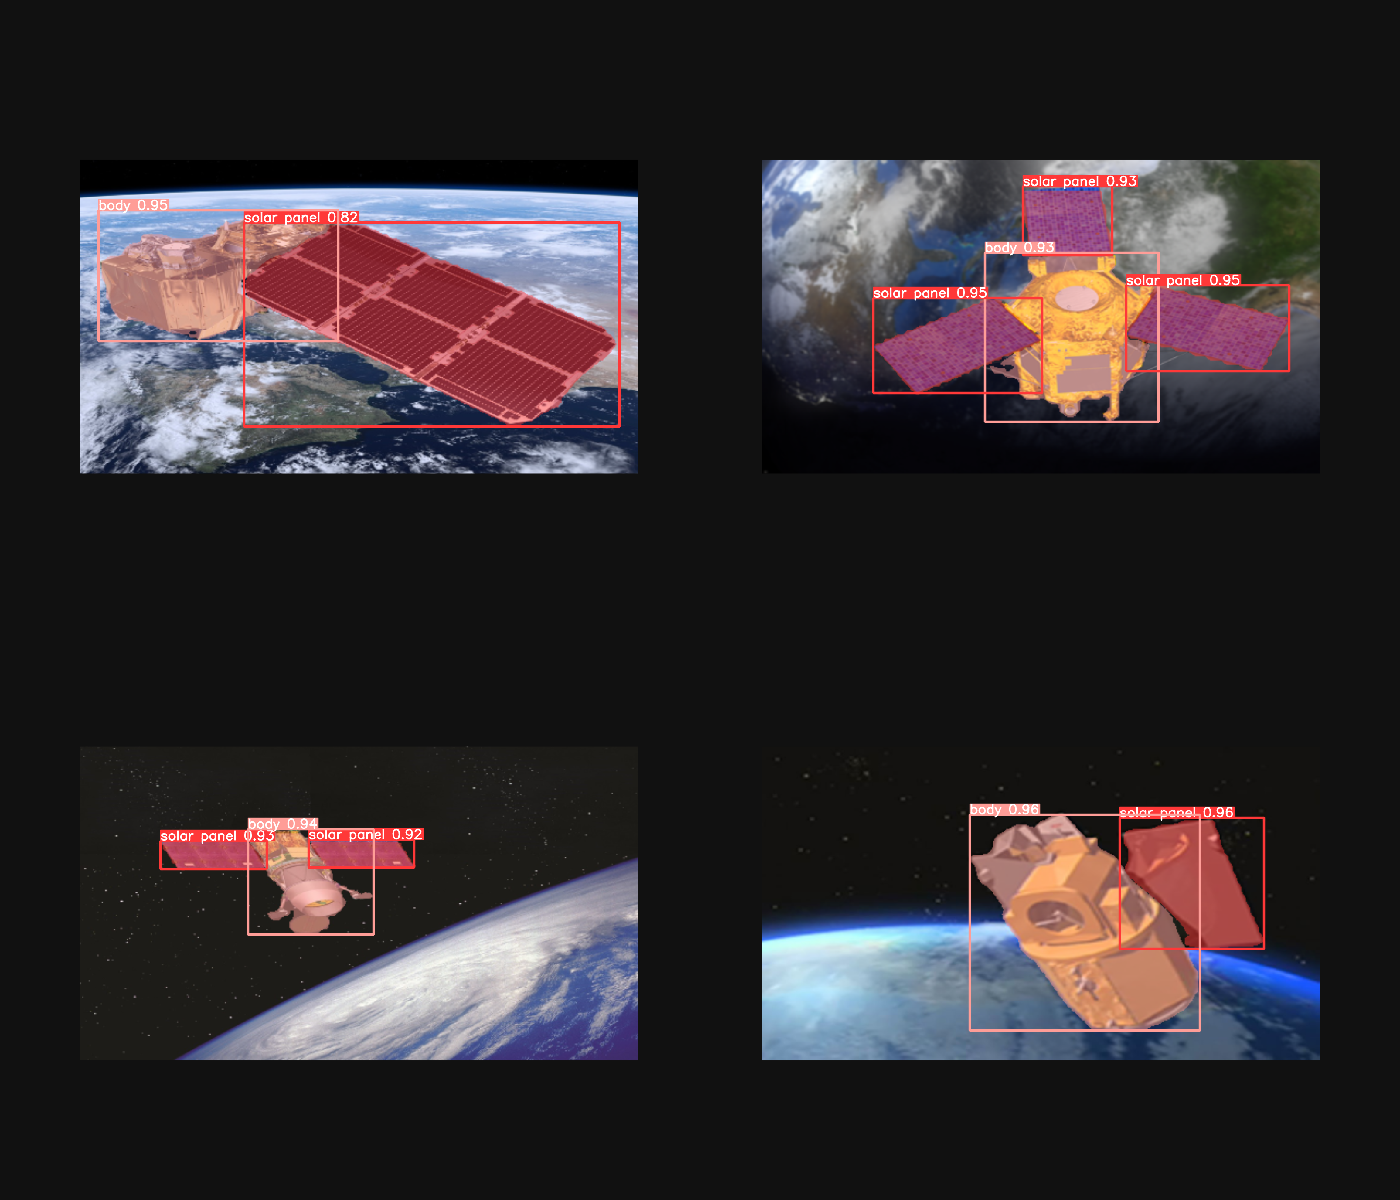

In [26]:
rows = cols = 2
grid = make_subplots(rows=rows, cols=cols)
predictions_path = 'runs/segment/predict'
for row, col, image in zip(
    sorted(list(range(1, rows+1))*cols),
    list(range(1, cols+1))*rows,
    os.listdir(predictions_path)
):
    # Add image with predicted segmentation mask and box with label
    grid.add_trace(
        px.imshow(
            # BGR -> RGB
            cv.cvtColor(
                cv.imread(os.path.join(predictions_path, image)),
                cv.COLOR_BGR2RGB
            )
        ).data[0],
        row=row,
        col=col
    )
# Configure plot
grid.update_layout(
    width=1400, 
    height=1200
).update_xaxes(
    visible=False
).update_yaxes(
    visible=False
).show()